In [53]:
import logging, sys
logging.disable(sys.maxsize)
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from pylab import rcParams
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
import datetime
from dateutil.relativedelta import relativedelta
import pickle as pck
from pmdarima.arima import auto_arima
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import math

In [2]:
bitcoin = pd.read_csv("../data/bitcoin.csv")

In [3]:
bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4437 entries, 0 to 4436
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Fecha     4437 non-null   object
 1   Último    4437 non-null   object
 2   Apertura  4437 non-null   object
 3   Máximo    4437 non-null   object
 4   Mínimo    4437 non-null   object
 5   Vol.      4437 non-null   object
 6   % var.    4437 non-null   object
dtypes: object(7)
memory usage: 242.8+ KB


In [4]:
bitcoin.describe()

Fecha Último Apertura Máximo Mínimo   Vol. % var.
count         4437   4437     4437   4437   4437   4437   4437
unique        4437   3485     3478   3470   3480   3965   1515
top     09.09.2022    0,1      0,1    0,1    0,1  1,05M  0,00%
freq             1    100      100     97    101      6    425

In [5]:
bitcoin.head()

Fecha    Último  Apertura    Máximo    Mínimo     Vol.  % var.
0  09.09.2022  20.742,8  19.318,8  20.743,7  19.294,1  359,40K   7,38%
1  08.09.2022  19.317,4  19.281,5  19.444,7  19.034,5  291,43K   0,19%
2  07.09.2022  19.281,5  18.786,3  19.445,9  18.548,4  319,10K   2,64%
3  06.09.2022  18.786,4  19.793,4  20.169,3  18.723,3  402,43K  -5,09%
4  05.09.2022  19.793,1  19.999,9  20.042,9  19.650,7  238,71K  -1,03%

We can see that "Fecha" is in descending order, so we need to change that

In [6]:
bitcoin.describe()

Fecha Último Apertura Máximo Mínimo   Vol. % var.
count         4437   4437     4437   4437   4437   4437   4437
unique        4437   3485     3478   3470   3480   3965   1515
top     09.09.2022    0,1      0,1    0,1    0,1  1,05M  0,00%
freq             1    100      100     97    101      6    425

In [7]:
fig = px.line(bitcoin, x="Fecha", y="Máximo")
fig.show()

The above plot shows the fluctuation of Bitcoin price in a strange way, due to the column "Fecha" being in descending order. We'll get it right and plot it again to see how prices have changed

In [8]:
bitcoin.columns = ["date", "close", "open", "high", "low", "vol", "var_%"]

In [9]:
bitcoin.head()

date     close      open      high       low      vol   var_%
0  09.09.2022  20.742,8  19.318,8  20.743,7  19.294,1  359,40K   7,38%
1  08.09.2022  19.317,4  19.281,5  19.444,7  19.034,5  291,43K   0,19%
2  07.09.2022  19.281,5  18.786,3  19.445,9  18.548,4  319,10K   2,64%
3  06.09.2022  18.786,4  19.793,4  20.169,3  18.723,3  402,43K  -5,09%
4  05.09.2022  19.793,1  19.999,9  20.042,9  19.650,7  238,71K  -1,03%

In [10]:
bitcoin["date"].describe()

count           4437
unique          4437
top       09.09.2022
freq               1
Name: date, dtype: object

Now let's change type of date to date time to work with time series

In [11]:
bitcoin["date"]= pd.to_datetime(bitcoin["date"], dayfirst=True)

In [12]:
bitcoin.head()

date     close      open      high       low      vol   var_%
0 2022-09-09  20.742,8  19.318,8  20.743,7  19.294,1  359,40K   7,38%
1 2022-09-08  19.317,4  19.281,5  19.444,7  19.034,5  291,43K   0,19%
2 2022-09-07  19.281,5  18.786,3  19.445,9  18.548,4  319,10K   2,64%
3 2022-09-06  18.786,4  19.793,4  20.169,3  18.723,3  402,43K  -5,09%
4 2022-09-05  19.793,1  19.999,9  20.042,9  19.650,7  238,71K  -1,03%

In [13]:
bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4437 entries, 0 to 4436
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    4437 non-null   datetime64[ns]
 1   close   4437 non-null   object        
 2   open    4437 non-null   object        
 3   high    4437 non-null   object        
 4   low     4437 non-null   object        
 5   vol     4437 non-null   object        
 6   var_%   4437 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 242.8+ KB


We see that every column, except date, is of type object when we know they should be floats. 
Let's clean the values with characters not needed and change the type of each column

In [14]:
num = bitcoin.drop("date", axis = 1)

In [15]:
num.head()

close      open      high       low      vol   var_%
0  20.742,8  19.318,8  20.743,7  19.294,1  359,40K   7,38%
1  19.317,4  19.281,5  19.444,7  19.034,5  291,43K   0,19%
2  19.281,5  18.786,3  19.445,9  18.548,4  319,10K   2,64%
3  18.786,4  19.793,4  20.169,3  18.723,3  402,43K  -5,09%
4  19.793,1  19.999,9  20.042,9  19.650,7  238,71K  -1,03%

In the cell below we replace the letters and symbols that we don't want

In [16]:
for i in num:
    for j in range(len(num)):
        num[i][j] = num[i][j].replace(".", "")
        num[i][j] = num[i][j].replace(",", ".")
        if "%" in num[i][j]:
            num[i][j] = num[i][j].replace("%", "")
        elif "K" in num[i][j]:
            num[i][j] = float(num[i][j].replace("K", ""))
        elif "M" in num[i][j]:
            num[i][j] = float(num[i][j].replace("M", "")) * 1000
            if num[i][j] > 15:
                num[i][j] = num[i][j] / 1000
        elif "B" in num[i][j]:
            num[i][j] = float(num[i][j].replace("B", "")) * 1000
        elif num[i][j] == "-":
            num[i][j] = 0
        else:
            pass

In [17]:
num.head()

close     open     high      low     vol  var_%
0  20742.8  19318.8  20743.7  19294.1   359.4   7.38
1  19317.4  19281.5  19444.7  19034.5  291.43   0.19
2  19281.5  18786.3  19445.9  18548.4   319.1   2.64
3  18786.4  19793.4  20169.3  18723.3  402.43  -5.09
4  19793.1  19999.9  20042.9  19650.7  238.71  -1.03

In [18]:
num = num.astype(float)

In [19]:
bitcoin[["close", "open", "high", "low", "vol", "var_%"]] = num

Now we sort the dates in descending order and take some values that don't add much to the total, I chose to keep values from 2012 onwards.

In [20]:
bitcoin = bitcoin.sort_values(by='date').reset_index(drop = True)

In [21]:
bitcoin = bitcoin[bitcoin["date"] >= "2012-01-01"]

In [22]:
bitcoin = bitcoin.set_index("date")

In [23]:
bitcoin.insert(loc = 0, column = "date", value = bitcoin.index)

In [24]:
bitcoin

date    close     open     high      low     vol  var_%
date                                                                    
2012-01-01 2012-01-01      5.3      4.7      5.5      4.6  108.51  11.65
2012-01-02 2012-01-02      5.2      5.3      5.5      4.8   69.15  -0.95
2012-01-03 2012-01-03      4.9      5.2      5.3      4.7  125.17  -6.51
2012-01-04 2012-01-04      5.6      4.9      5.7      4.8  131.17  14.14
2012-01-05 2012-01-05      6.9      5.6      7.2      5.6  182.33  24.78
...               ...      ...      ...      ...      ...     ...    ...
2022-09-05 2022-09-05  19793.1  19999.9  20042.9  19650.7  238.71  -1.03
2022-09-06 2022-09-06  18786.4  19793.4  20169.3  18723.3  402.43  -5.09
2022-09-07 2022-09-07  19281.5  18786.3  19445.9  18548.4  319.10   2.64
2022-09-08 2022-09-08  19317.4  19281.5  19444.7  19034.5  291.43   0.19
2022-09-09 2022-09-09  20742.8  19318.8  20743.7  19294.1  359.40   7.38

[3905 rows x 7 columns]

Data is cleaned and date column in correct order. 
Next thing is to check if the dates follows the same frequency. That's important for any Time Series because the frequency must be constant

In [25]:
bit_2 = bitcoin.copy()

bit_2['date_shift'] = bit_2['date'].shift()  

In [26]:
bit_2.head()

date  close  open  high  low     vol  var_% date_shift
date                                                                   
2012-01-01 2012-01-01    5.3   4.7   5.5  4.6  108.51  11.65        NaT
2012-01-02 2012-01-02    5.2   5.3   5.5  4.8   69.15  -0.95 2012-01-01
2012-01-03 2012-01-03    4.9   5.2   5.3  4.7  125.17  -6.51 2012-01-02
2012-01-04 2012-01-04    5.6   4.9   5.7  4.8  131.17  14.14 2012-01-03
2012-01-05 2012-01-05    6.9   5.6   7.2  5.6  182.33  24.78 2012-01-04

In [27]:
bit_2['diff'] = bit_2['date'] - bit_2['date_shift']

In [28]:
bit_2.head()

date  close  open  high  low     vol  var_% date_shift   diff
date                                                                          
2012-01-01 2012-01-01    5.3   4.7   5.5  4.6  108.51  11.65        NaT    NaT
2012-01-02 2012-01-02    5.2   5.3   5.5  4.8   69.15  -0.95 2012-01-01 1 days
2012-01-03 2012-01-03    4.9   5.2   5.3  4.7  125.17  -6.51 2012-01-02 1 days
2012-01-04 2012-01-04    5.6   4.9   5.7  4.8  131.17  14.14 2012-01-03 1 days
2012-01-05 2012-01-05    6.9   5.6   7.2  5.6  182.33  24.78 2012-01-04 1 days

In [29]:
bit_2[bit_2['diff'] != '1 days'].index 

DatetimeIndex(['2012-01-01'], dtype='datetime64[ns]', name='date', freq=None)

We see there are no values with a "diff" higher than "1 days", so we can say all values are following a daily frequency.
The NaT in first row is expected, since there is no value previous to the first one. 

We plot again tha data to see how it has changed.

In [30]:
def show_plot(df, col1, col2):
    fig = px.line(df, x = col1, y = col2)

    return fig.show()

Having this "bitcoin" dataset with bitcoin pricing evolution from 2012 to September 9th of 2022 we'll analyze bitcoin prices and try different Time Series models to predict them

In [31]:
show_plot(bitcoin, "date", "close")

Dataset 2017-22

In [32]:
bitcoin_1 = bitcoin[bitcoin["date"] >= "2017-01-01"]
bitcoin_1.head()

date   close    open    high     low     vol  var_%
date                                                                
2017-01-01 2017-01-01   995.4   963.4  1001.6   956.1   41.15   3.33
2017-01-02 2017-01-02  1017.0   995.4  1031.7   990.2   64.95   2.17
2017-01-03 2017-01-03  1033.3  1017.0  1035.5  1006.5   54.79   1.60
2017-01-04 2017-01-04  1135.4  1033.3  1148.5  1022.3  156.27   9.88
2017-01-05 2017-01-05   989.3  1135.4  1150.6   874.5  240.01 -12.86

In [33]:
fig = px.line(bitcoin_1, x="date", y="close")
fig.show()

In [34]:
def show_halving_plots(df):

    bitcoin_12 = df[df["date"] < "2013-01-01"]
    bitcoin_13 = df[(df["date"] >= "2013-01-01") & (df["date"] < "2014-01-01")]
    bitcoin_14 = df[(df["date"] >= "2014-01-01") & (df["date"] < "2015-01-01")]
    bitcoin_15 = df[(df["date"] >= "2015-01-01") & (df["date"] < "2016-01-01")]
    bitcoin_16 = df[(df["date"] >= "2016-01-01") & (df["date"] < "2017-01-01")]
    bitcoin_17 = df[(df["date"] >= "2017-01-01") & (df["date"] > "2018-01-01")]
    bitcoin_18 = df[(df["date"] >= "2018-01-01") & (df["date"] < "2019-01-01")]
    bitcoin_19 = df[(df["date"] >= "2019-01-01") & (df["date"] < "2020-01-01")]
    bitcoin_20 = df[(df["date"] >= "2020-01-01") & (df["date"] < "2021-01-01")]
    bitcoin_21 = df[(df["date"] >= "2021-01-01") & (df["date"] < "2022-01-01")]
    bitcoin_22 = df[(df["date"] >= "2022-01-01")]
    fig = px.line(bitcoin_12, y = "close", x = "date")
    fig.add_vline(x = "2012-11-28 00:00:00", line_width = 5, line_dash = "dash", line_color = "black")
    fig.show()
    fig = px.line(bitcoin_16, y = "close", x = "date")
    fig.add_vline(x = "2016-07-09 00:00:00", line_width = 5, line_dash = "dash", line_color = "black")
    fig.show()
    fig = px.line(bitcoin_20, y = "close", x = "date")
    fig.add_vline(x = "2020-05-11 00:00:00", line_width = 5, line_dash = "dash", line_color = "black")
    
    return fig.show()

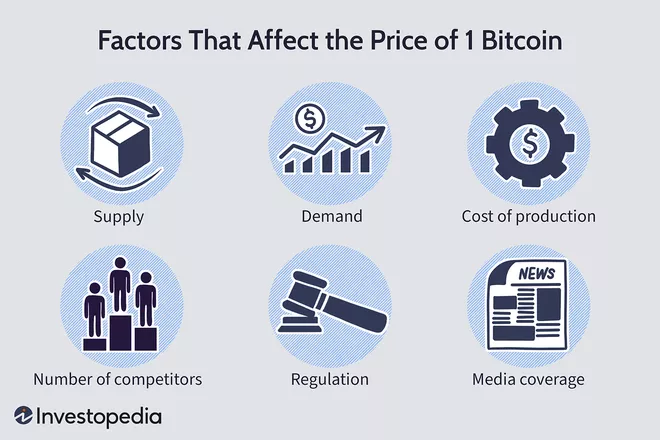

### Halving


Reduce by half

    - Quite effective methodology to avoid inflation
    - Having a fixed emission limit, it is achieved that the price of Bitcoin does nothing but rise

In [35]:
show_halving_plots(bitcoin)

In [37]:
bitcoin = bitcoin[["date", "close"]]

In [38]:
bitcoin.to_csv('../data/clean_data.csv')

We are going to use the values from column "close" to predict the future results.

In [39]:
bitcoin_close = bitcoin[["close"]]

In [40]:
bitcoin_close.head()

close
date             
2012-01-01    5.3
2012-01-02    5.2
2012-01-03    4.9
2012-01-04    5.6
2012-01-05    6.9

#### STATIONARITY

Basic properties of the distribution like the mean, variance and covariance are constant over time


In [41]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags = "auto") 
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [42]:
adf_test(bitcoin_close["close"])

Results of Dickey-Fuller Test:
Test Statistic                   -1.615436
p-value                           0.475123
#Lags Used                       29.000000
Number of Observations Used    3875.000000
Critical Value (1%)              -3.432039
Critical Value (5%)              -2.862286
Critical Value (10%)             -2.567167
dtype: float64


From adf_test we see there is no stationarity. The p-value returned is higher than the significance level o.o5, and Test Statistic is also higher than the Critical Value -2.86. Therefore we accept the null hypothesis: TS has no Stationarity

#### Decomposing

In [43]:
def decomposing(df):
    rcParams['figure.figsize'] = 18, 8
    decomposition = sm.tsa.seasonal_decompose(df, model='additive')
    fig = decomposition.plot()
    return plt.show()

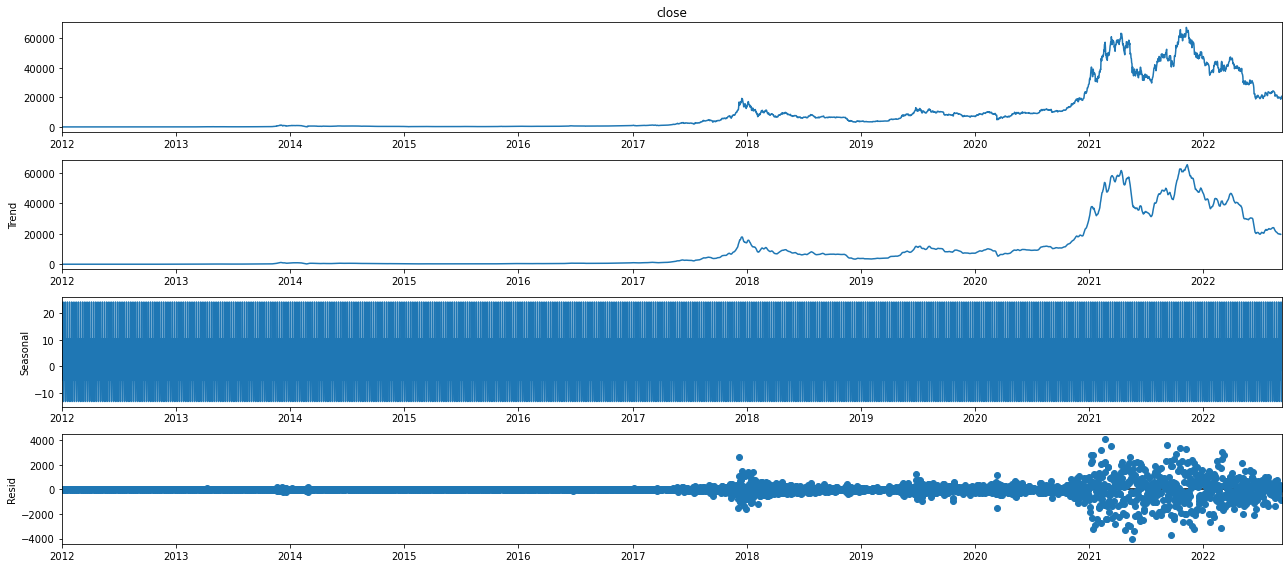

In [44]:
decomposing(bitcoin["close"])

For the whole data we see possible seasonality


We'll check for the years 21 and 22 only, so we can see in more detail.

In [45]:
bitcoin_21_22 = bitcoin[bitcoin["date"] >= "2021-01-01"]

In [46]:
bitcoin_21_22.to_csv('../data/clean_data_21_22.csv')

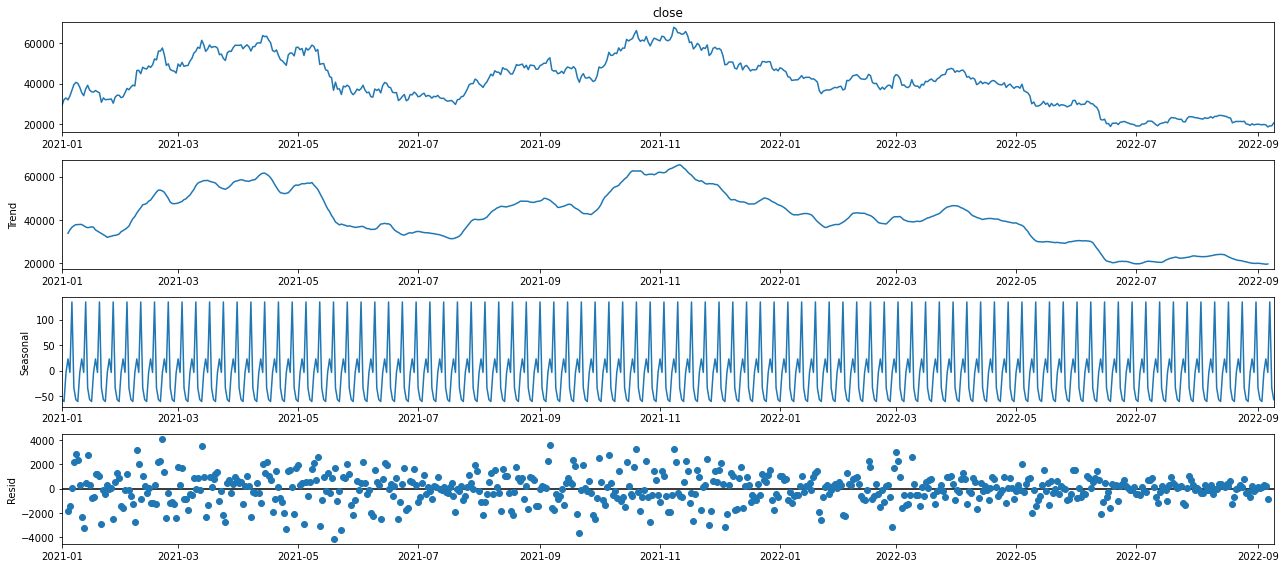

In [47]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(bitcoin_21_22["close"], model='additive')
fig = decomposition.plot()
plt.show()

We don't see Seasonality in this dataset. The Seasonal plot shows a cycle behaviour, but analysing the whole, we can't say there is a pattern in prices.

#### ACF PACF

In the cell below we check for ACF and PACF; autocorrelation and partial autocorrelation.

In [48]:
def acf_pacf(df):

    fig, axes = plt.subplots(1, 2, figsize= (30, 10))

    fig1 = sm.graphics.tsa.plot_acf(df,
                               lags = 20,                               
                               ax=axes[0])
    fig2 = sm.graphics.tsa.plot_pacf(df, lags = 20, 
                                ax=axes[1], method = "ywm")
    return fig1, fig2

(<Figure size 2160x720 with 2 Axes>, <Figure size 2160x720 with 2 Axes>)

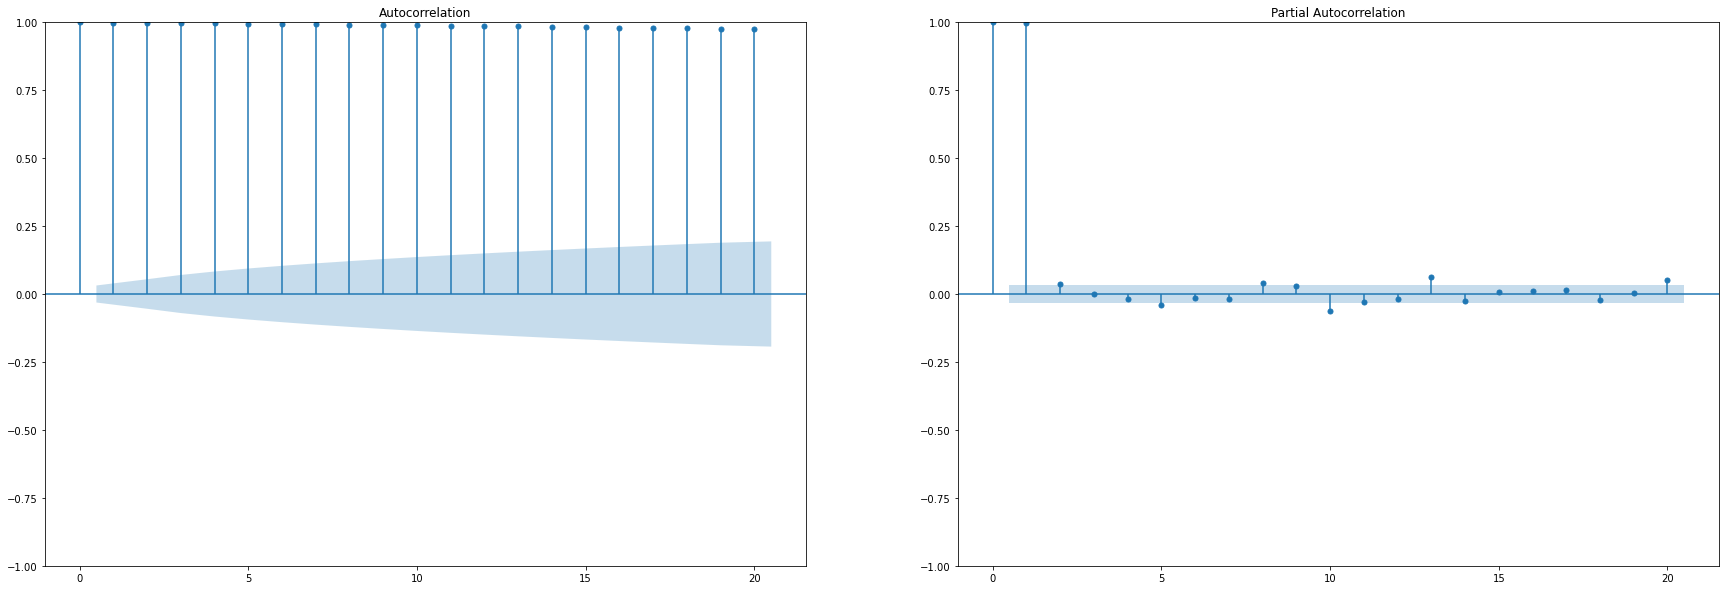

In [49]:
acf_pacf(bitcoin_close["close"])

By looking at the plots we see a high Autocorrelation, meaning that each value is highly correlated to the previous one.
For PACF we see significant correlation at lag 1 followed by correlations that are not significant

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

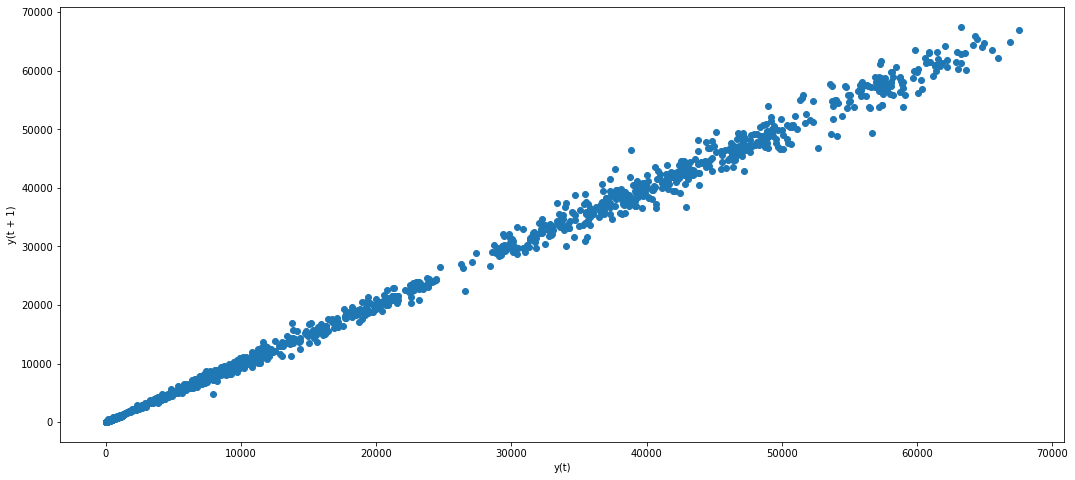

In [50]:
pd.plotting.lag_plot(bitcoin_close["close"])

On the plot above we can almost see a straight line. This tells us that the previous value can be used to predict the next one, to do so, AR(1) model is the one to use

------

### AR

In [51]:
bitcoin_21_22 = bitcoin_21_22[["date", "close"]]

In [148]:
max_train = math.ceil(len(bitcoin_21_22) * 0.80)  

In [55]:
train_2 = bitcoin_21_22.iloc[:max_train,:]['close']
test_2 = bitcoin_21_22.iloc[max_train:,:]['close']

In [57]:
AR_model_2 = AutoReg(bitcoin_21_22["close"], lags = 1)
AR_fit_2 = AR_model_2.fit()
with open("../models/AR_model_2.pkl", "wb") as file:
    pck.dump(AR_fit_2,file)
AR_predictions_2 = AR_fit_2.predict(start = len(train_2), end=len(train_2)+len(test_2)-1, dynamic=False)

print(AR_fit_2.params)
print(AR_fit_2.summary())

const       313.833202
close.L1      0.992079
dtype: float64
                            AutoReg Model Results                             
Dep. Variable:                  close   No. Observations:                  617
Model:                     AutoReg(1)   Log Likelihood               -5439.185
Method:               Conditional MLE   S.D. of innovations           1653.925
Date:                Fri, 16 Sep 2022   AIC                          10884.369
Time:                        10:46:36   BIC                          10897.639
Sample:                    01-02-2021   HQIC                         10889.529
                         - 09-09-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        313.8332    238.981      1.313      0.189    -154.561     782.228
close.L1       0.9921      0.006    178.902      0.000       0.981    

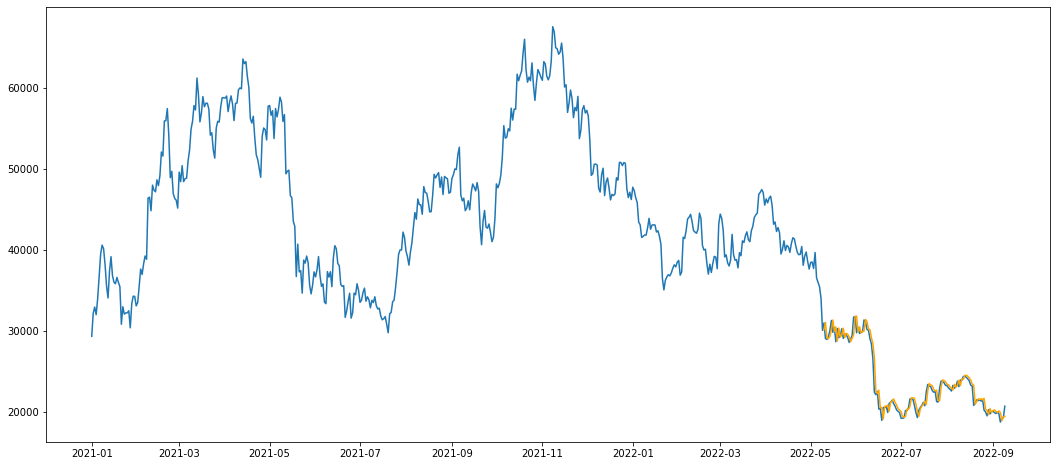

In [60]:
plt.plot(bitcoin_21_22["close"])
plt.plot(AR_predictions_2, color='orange')
plt.show()

In [61]:
future_pred_2 = AR_fit_2.predict(start = "2022-09-10", end = "2022-09-29", dynamic=False) 

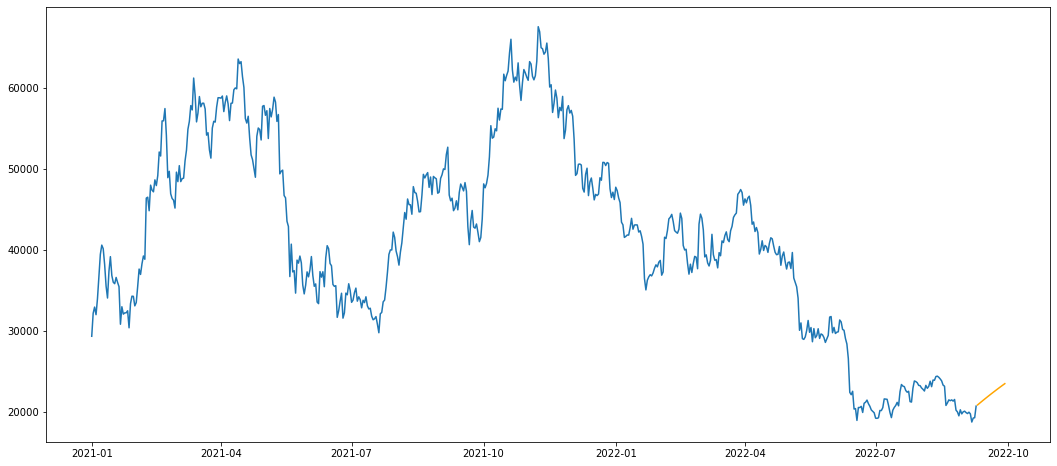

In [62]:
plt.plot(bitcoin_21_22["close"])
plt.plot(future_pred_2, color='orange')
plt.show()

Here, at least, we get a forecast with evolution similar to real fluctuation.

-----

#### ARIMA model

ARIMA is a Time Series model composed by: AR(autoregression), I(integrated) and MA(moving average)

    - The I represents the differencing of raw observations to allow for the time series to become stationary

    - The MA incorporates the dependency between an observation and a residual error from a moving average model applied to  
      lagged observations

Ckecking fot Stationarity between 2021-22

In [63]:
adf_test(bitcoin_21_22["close"])

Results of Dickey-Fuller Test:
Test Statistic                  -1.426083
p-value                          0.569710
#Lags Used                       0.000000
Number of Observations Used    616.000000
Critical Value (1%)             -3.441010
Critical Value (5%)             -2.866243
Critical Value (10%)            -2.569275
dtype: float64


From adf_test we see there is no stationarity. The p-value returned o.57 is higher than the significance level o.o5, and Test Statistic -1.43 is also higher than the Critical Value -2.86. Therefore we accept the null hypothesis: TS has no Stationarity

For ARIMA(p,d,q) model we need Stationary data, in this case we don't have it, thats why we need to apply differencing segment of ARIMA so we can have stationary data. 

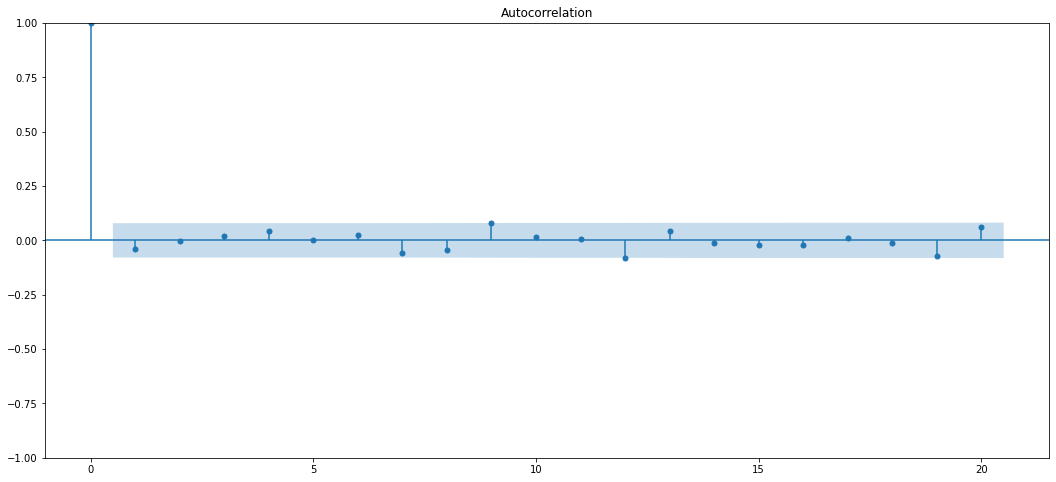

In [64]:
sm.graphics.tsa.plot_acf(bitcoin_21_22['close'].diff()[1:],
                               lags = 20)
plt.show()

We see that differentiating once is enough to deal with lack of stationarity. d = 0.

We also know that p = 0 from the autocorrelation before, and also it was the value we gave to the AR(1) model.
We just need the value for q so we can fit the model. 

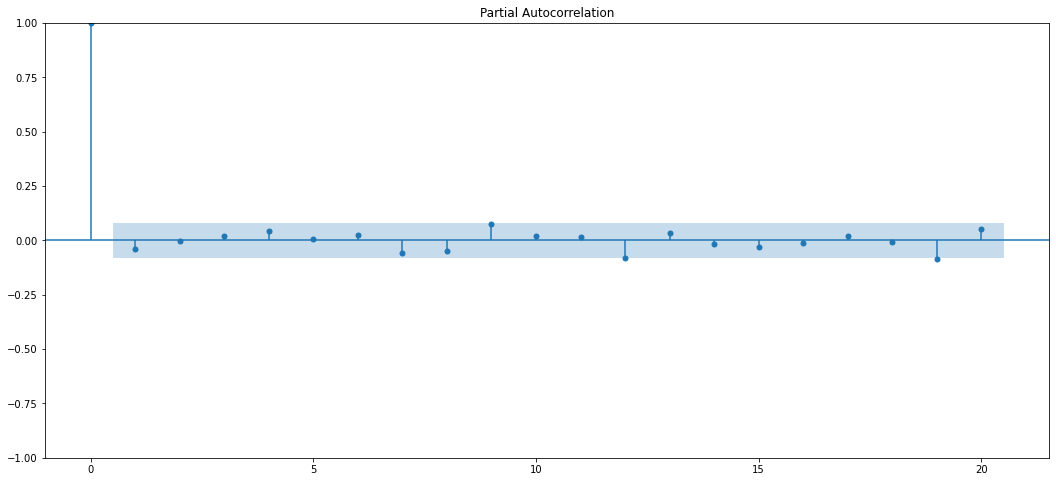

In [65]:
sm.graphics.tsa.plot_pacf(bitcoin_21_22['close'].diff()[1:],
                               lags = 20, method = "ywm")
plt.show()

In [149]:
ARIMA_model1 = ARIMA(bitcoin_21_22["close"], order = (0, 1, 0), freq ="D")
ARIMA_fit_1 = ARIMA_model1.fit()
ARIMA_fit_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                  617
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -5440.225
Date:                Fri, 16 Sep 2022   AIC                          10882.451
Time:                        11:05:32   BIC                          10886.874
Sample:                    01-01-2021   HQIC                         10884.171
                         - 09-09-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       2.74e+06   1.08e+05     25.471      0.000    2.53e+06    2.95e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.03   Jarque-Bera (JB):               124.49
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [150]:
with open("../models/ARIMA_model1.pkl", "wb") as file:
    pck.dump(ARIMA_model1,file)

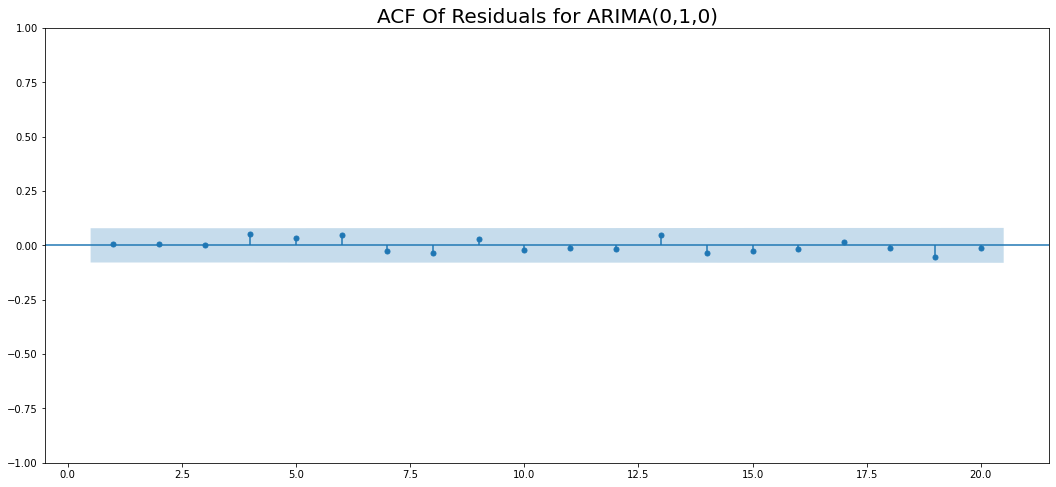

In [163]:
bitcoin_21_22["res_ARIMA_1"] = ARIMA_fit_1.resid
sgt.plot_acf(bitcoin_21_22["res_ARIMA_1"], zero = False, lags = 20)
plt.title("ACF Of Residuals for ARIMA(0,1,0)", size = 20)
plt.show()

In [152]:
ARIMA_predictions_1 = ARIMA_fit_1.predict(start = 494, end = 617, dynamic=False)


In [154]:
bitcoin_21_22["ARIMA_predictions_1"] = ARIMA_predictions_1

<AxesSubplot:xlabel='date'>

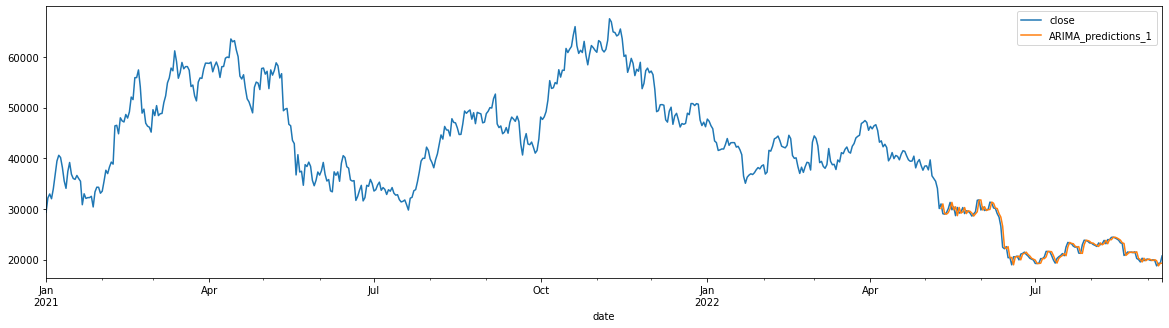

In [155]:
bitcoin_21_22[["close", "ARIMA_predictions_1"]].plot(figsize=(20, 5))

In [156]:
start = datetime.datetime.strptime("2022-09-10", "%Y-%m-%d")
date_list = [start + relativedelta(days = x) for x in range(0,12)]
future_prediction = pd.DataFrame(index = date_list, columns= bitcoin_21_22.columns)
bitcoin_close_pred = pd.concat([bitcoin_21_22, future_prediction])

In [158]:
bitcoin_close_pred["future_prediction"] = ARIMA_fit_1.predict(start  = 617, end = 629, dynamic=True)

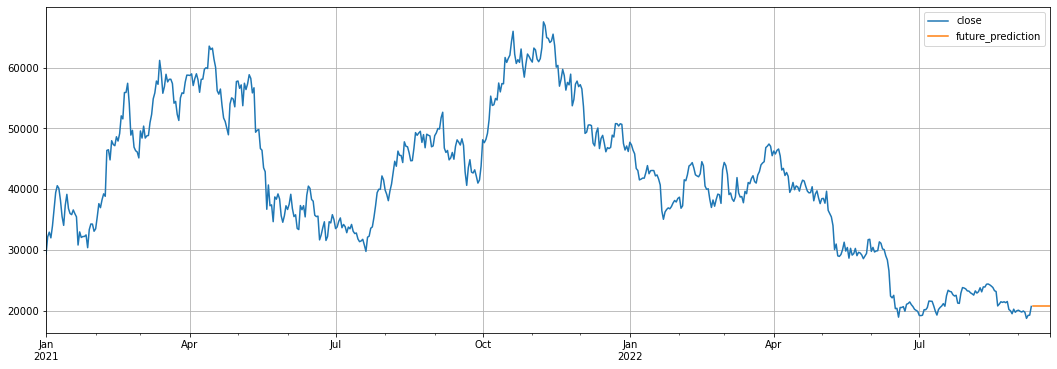

In [159]:
bitcoin_close_pred[["close","future_prediction"]].plot(figsize=(18, 6))
plt.grid(True)

In [161]:
bitcoin_close_pred_22 = bitcoin_close_pred["2022-01-01":]

In the plot below we see in more detail the evolution and prediction of year 2022

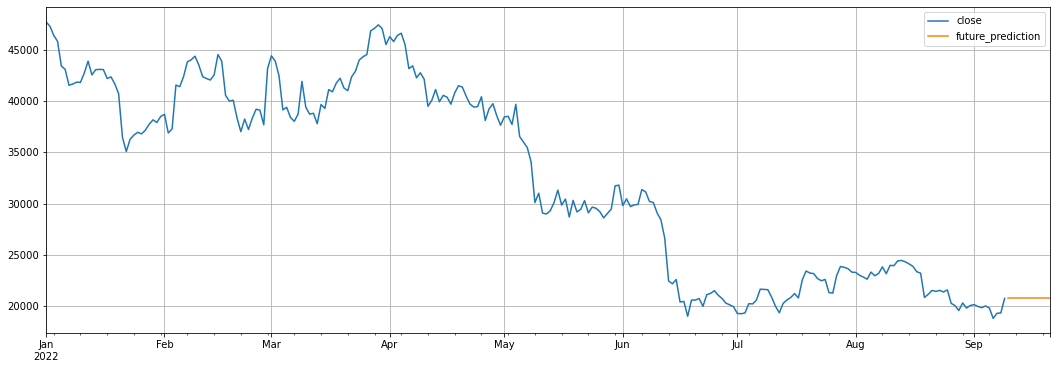

In [162]:
bitcoin_close_pred_22[["close","future_prediction"]].plot(figsize=(18, 6))
plt.grid(True)


##### Second model of ARIMA with wither period of time data, trying to get better results

### SKTIME

Now we're going to use Sktime library to select the best possible models for ARIMA

In [97]:
sk_bitcoin = bitcoin[["date", "close"]].set_index("date")

In [98]:
bit_train, bit_test = temporal_train_test_split(sk_bitcoin, test_size = 415)

In [99]:
auto_Arima = auto_arima(sk_bitcoin, start_p = 1, start_q = 1,
                      test='adf', max_p = 5, max_q = 5,          
                      seasonal = False,   
                      start_P = 0, D = None, 
                      trace = True, error_action = 'ignore',  
                      suppress_warnings = True, 
                      stepwise = True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=62209.136, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=62209.599, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=62207.135, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=62207.152, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62207.825, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=62209.134, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=62211.133, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=62205.375, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=62207.375, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=62207.377, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=62205.393, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=62209.374, Time=0.15 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.354 seconds


In [100]:
auto_Arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3905
Model:               SARIMAX(1, 1, 0)   Log Likelihood              -31100.688
Date:                Fri, 16 Sep 2022   AIC                          62205.375
Time:                        10:48:15   BIC                          62217.915
Sample:                    01-01-2012   HQIC                         62209.826
                         - 09-09-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0338      0.007     -4.697      0.000      -0.048      -0.020
sigma2      4.866e+05   3085.480    157.692      0.000    4.81e+05    4.93e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             90150.75
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):            1746.43   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [101]:
sk_pred = auto_Arima.predict(30)

In [102]:
sk_pred = pd.DataFrame(sk_pred)

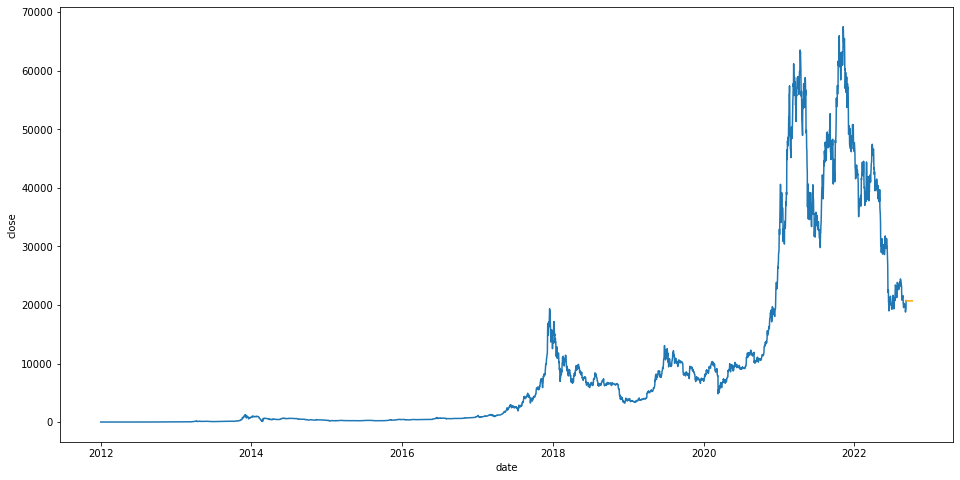

In [103]:
fig, ax = plt.subplots(1, figsize=(16,8))
sns.lineplot(data = sk_bitcoin, y = "close", x = sk_bitcoin.index);
sns.lineplot(data= sk_pred, x = sk_pred.index, y = 0,color = 'orange');
plt.show()

## PROPHET 

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data

In [104]:
bitcoin_21_22 = bitcoin[bitcoin["date"] >= "2021-01-01"]

In [105]:
bitcoin_21_22

date    close
date                          
2021-01-01 2021-01-01  29359.9
2021-01-02 2021-01-02  32193.3
2021-01-03 2021-01-03  32958.9
2021-01-04 2021-01-04  32022.6
2021-01-05 2021-01-05  33991.5
...               ...      ...
2022-09-05 2022-09-05  19793.1
2022-09-06 2022-09-06  18786.4
2022-09-07 2022-09-07  19281.5
2022-09-08 2022-09-08  19317.4
2022-09-09 2022-09-09  20742.8

[617 rows x 2 columns]

In [106]:
bitcoin_21_22_prophet = bitcoin_21_22[["close", "date"]].rename(columns = {"close": 'y', "date": "ds"})

In [107]:
bitcoin_21_22_prophet.head()

y         ds
date                          
2021-01-01  29359.9 2021-01-01
2021-01-02  32193.3 2021-01-02
2021-01-03  32958.9 2021-01-03
2021-01-04  32022.6 2021-01-04
2021-01-05  33991.5 2021-01-05

In [108]:
bitcoin_fbp = Prophet()

bitcoin_fbp.fit(bitcoin_21_22_prophet)

with open("../models/bitcoin_fbp.pkl", "wb") as file:
    pck.dump(bitcoin_fbp,file)

bitcoin_prophet = bitcoin_fbp.make_future_dataframe(periods = 120, freq = "D")

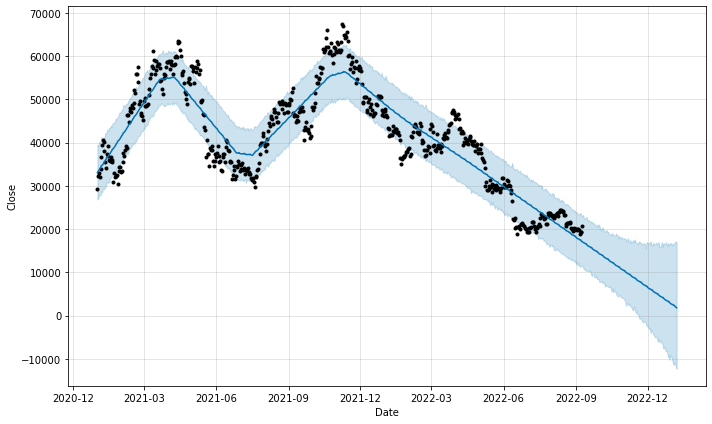

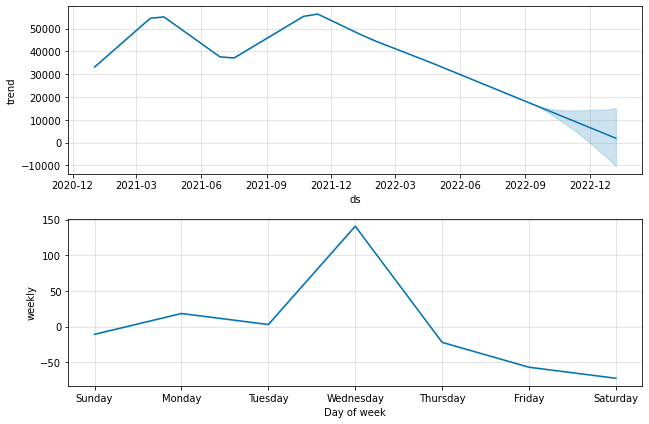

In [109]:
bitcoin_prophet_future = bitcoin_fbp.predict(bitcoin_prophet)

bitcoin_fbp.plot(bitcoin_prophet_future, xlabel = 'Date', ylabel = 'Close')
fig = bitcoin_fbp.plot_components(bitcoin_prophet_future)
plt.show()

In the first plot: 
    
    - Black dots show the real data that we have in the original Dataset 
    
    - Blue line is the forecasted data, the data predicted. 

As we can see the predictions show that the price of Bitcoin will drop in the following months

Cross Validation

In [111]:
fbp_cv = cross_validation(bitcoin_fbp, initial = '590', period = '120 days', horizon = '365 days',
                         parallel="processes")
fbp_cv.head()

ds          yhat    yhat_lower    yhat_upper        y     cutoff
0 2021-01-13  42394.139714  40067.070100  44594.380019  37382.2 2021-01-12
1 2021-01-14  45059.206766  42822.117101  47074.364065  39175.7 2021-01-12
2 2021-01-15  43384.595612  41056.212282  45605.586467  36845.8 2021-01-12
3 2021-01-16  44575.896872  42466.591287  46717.634533  36019.5 2021-01-12
4 2021-01-17  43977.686854  41862.736704  46216.329242  35839.6 2021-01-12

In [112]:
#checking performance metrics for ERROR

bitcoin_prophet_future_pm = performance_metrics(fbp_cv)

In [113]:
bitcoin_prophet_future_pm

horizon           mse           rmse            mae      mape     mdape  \
0    37 days  2.343130e+08   15307.284520   13986.622496  0.358702  0.366443   
1    38 days  2.391222e+08   15463.577724   14145.978054  0.362630  0.374419   
2    39 days  2.436844e+08   15610.393994   14285.483426  0.365950  0.374974   
3    40 days  2.488141e+08   15773.843074   14426.150844  0.370016  0.377531   
4    41 days  2.537633e+08   15929.951067   14573.247927  0.373874  0.388532   
..       ...           ...            ...            ...       ...       ...   
324 361 days  2.940725e+10  171485.420519  134282.931618  3.899492  5.286174   
325 362 days  2.962605e+10  172122.190571  134893.125621  3.940548  5.306082   
326 363 days  2.982809e+10  172708.099633  135466.778343  3.977202  5.317301   
327 364 days  3.003689e+10  173311.548205  136062.320719  4.013638  5.326265   
328 365 days  3.026983e+10  173982.279663  136679.237329  4.044118  5.335399   

        smape  coverage  
0    0.293127  0.100917  
1    0.295860  0.110092  
2    0.298098  0.119266  
3    0.300554  0.128440  
4    0.302994  0.137615  
..        ...       ...  
324  1.038481  0.333333  
325  1.044393  0.333333  
326  1.049876  0.333333  
327  1.055732  0.333333  
328  1.060956  0.333333  

[329 rows x 8 columns]

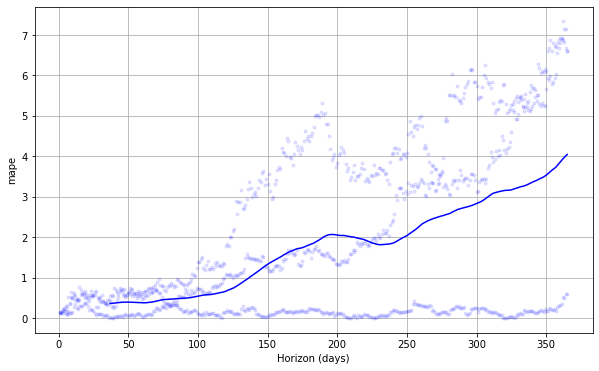

In [114]:
fig = plot_cross_validation_metric(fbp_cv, metric = 'mape')

Here we see error metric MAPE through the days prediccted in the future. The blue line represents the MAPE that tends to increase as the time goes by. 

##### New prophet facebook setting a different seasonality and longer period of time 

In [115]:
bitcoin_17_22_prophet = bitcoin[bitcoin["date"] >= "2017-01-01"].rename(columns = {"close": 'y', "date": "ds"})

In [116]:
bitcoin_17_22_prophet.to_csv('../data/clean_data_17_22.csv')

2017-22

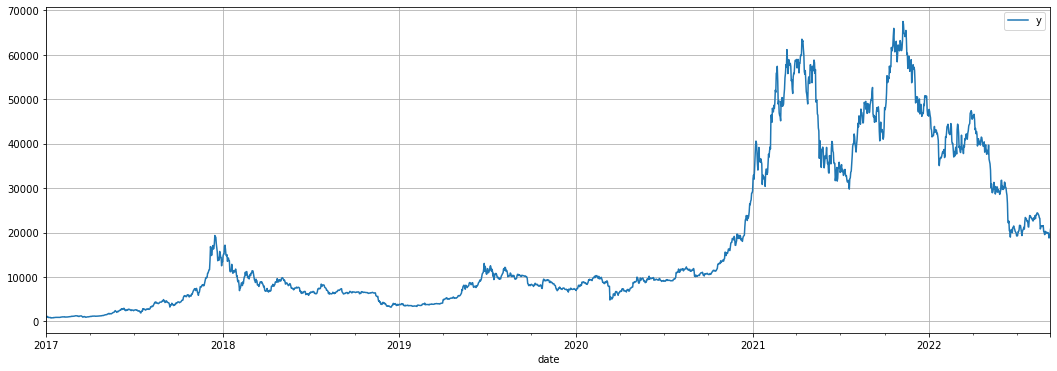

In [117]:
bitcoin_17_22_prophet[["y"]].plot(figsize=(18, 6))
plt.grid(True)

In [167]:
bitcoin_fbp_2 = Prophet(weekly_seasonality = False)
bitcoin_fbp_2.add_seasonality(name = "yearly", period = 1460, fourier_order = 15)

bitcoin_fbp_2.fit(bitcoin_17_22_prophet)
with open("../models/bitcoin_fbp_2.pkl", "wb") as file:
    pck.dump(bitcoin_fbp,file)
bitcoin_prophet_2 = bitcoin_fbp_2.make_future_dataframe(periods = 30, freq = "D")

Prophet(weekly_seasonality = False)

model.add_seasonality(name = "yearly", period = 1460, fourier_order = 15)

model.fit(df)

pred = model.make_future_dataframe(periods = 30, freq = "D")

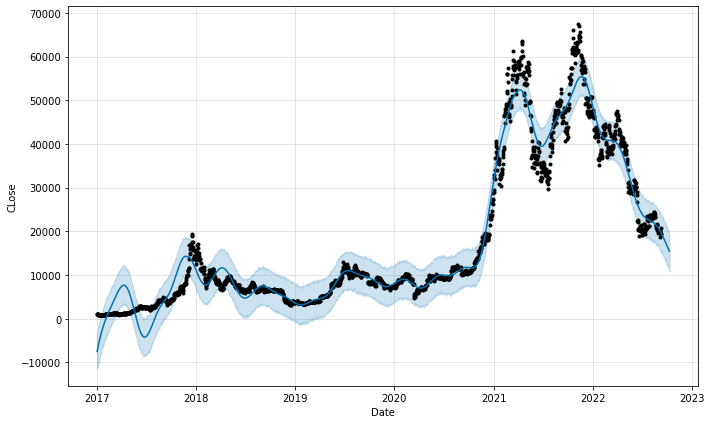

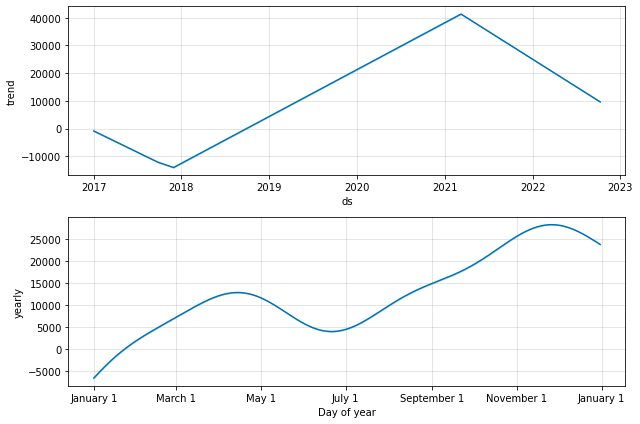

In [168]:
bitcoin_prophet_future_2 = bitcoin_fbp_2.predict(bitcoin_prophet_2)

bitcoin_fbp_2.plot(bitcoin_prophet_future_2, xlabel = 'Date', ylabel = 'CLose')
fig = bitcoin_fbp_2.plot_components(bitcoin_prophet_future_2)
plt.show()

Here we get a better prediction, it doesn't perform well when predicting peaks, but it follows tendencies pretty well. 
So far is the best we got

Change points

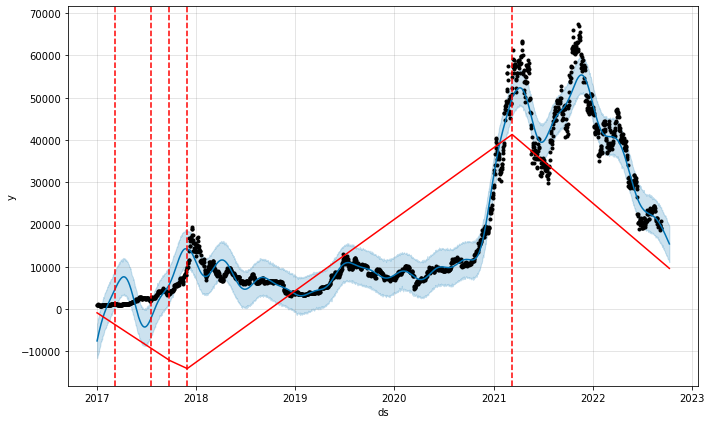

In [120]:
from prophet.plot import add_changepoints_to_plot
fig = bitcoin_fbp_2.plot(bitcoin_prophet_future_2)
a = add_changepoints_to_plot(fig.gca(), bitcoin_fbp_2, bitcoin_prophet_future_2)

In [121]:
fbp_cv_2 = cross_validation(bitcoin_fbp_2, initial = '2078', period = '30 days', horizon = '365 days',
                         parallel="processes")
fbp_cv_2.head()

ds         yhat   yhat_lower   yhat_upper       y     cutoff
0 2017-01-04  1034.596584  1031.833435  1037.855285  1135.4 2017-01-03
1 2017-01-05  1021.690916  1005.807755  1037.210993   989.3 2017-01-03
2 2017-01-06   995.452236   962.644062  1026.879811   886.2 2017-01-03
3 2017-01-07   956.815355   905.352329  1007.345145   888.9 2017-01-03
4 2017-01-08   906.777873   835.873070   977.305324   900.9 2017-01-03

In [122]:
bitcoin_prophet_future_pm_2 = performance_metrics(fbp_cv_2)

In [123]:
bitcoin_prophet_future_pm_2

horizon           mse          rmse           mae      mape     mdape  \
0    37 days  1.381139e+08  11752.185972   6931.667482  0.858701  0.330878   
1    38 days  1.527865e+08  12360.684294   7334.092346  0.912179  0.364107   
2    39 days  1.687344e+08  12989.781974   7748.086849  0.967494  0.396891   
3    40 days  1.861277e+08  13642.864202   8176.491286  1.024734  0.423077   
4    41 days  2.048258e+08  14311.735918   8612.286339  1.083944  0.446624   
..       ...           ...           ...           ...       ...       ...   
324 361 days  1.345069e+09  36675.185136  22284.077945  1.409880  0.707093   
325 362 days  1.350006e+09  36742.431562  22316.541575  1.410422  0.705118   
326 363 days  1.354998e+09  36810.304013  22350.738515  1.412501  0.707436   
327 364 days  1.360563e+09  36885.815423  22387.649881  1.414504  0.706194   
328 365 days  1.366405e+09  36964.918399  22420.062096  1.416448  0.705118   

        smape  coverage  
0    0.629688  0.162494  
1    0.654772  0.148323  
2    0.679770  0.135569  
3    0.704403  0.125413  
4    0.728712  0.116675  
..        ...       ...  
324  0.942040  0.064478  
325  0.941320  0.064714  
326  0.940753  0.065187  
327  0.940164  0.066131  
328  0.938955  0.066604  

[329 rows x 8 columns]

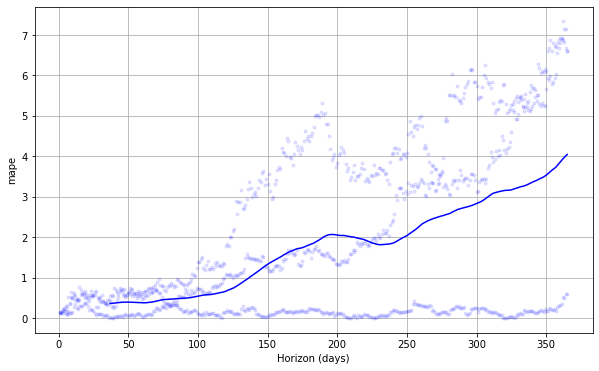

In [124]:
fig = plot_cross_validation_metric(fbp_cv, metric = 'mape')

In [125]:
prophet_future_values = bitcoin_prophet_future_2[bitcoin_prophet_future_2["ds"] > "2022-09-09"]

In [126]:
prophet_future_values = prophet_future_values[["ds", "yhat"]].rename(columns = {"yhat": 'close', "ds": "date"})

In [127]:
prophet_future_values = prophet_future_values.set_index("date")

In [128]:
prophet_future_values.insert(loc = 0, column = "date", value = prophet_future_values.index)

In [129]:
prophet_future_values.head(30)

date         close
date                               
2022-09-10 2022-09-10  19469.213938
2022-09-11 2022-09-11  19346.097725
2022-09-12 2022-09-12  19220.983343
2022-09-13 2022-09-13  19093.960350
2022-09-14 2022-09-14  18965.121326
2022-09-15 2022-09-15  18834.561523
2022-09-16 2022-09-16  18702.378508
2022-09-17 2022-09-17  18568.671800
2022-09-18 2022-09-18  18433.542510
2022-09-19 2022-09-19  18297.092969
2022-09-20 2022-09-20  18159.426370
2022-09-21 2022-09-21  18020.646394
2022-09-22 2022-09-22  17880.856856
2022-09-23 2022-09-23  17740.161339
2022-09-24 2022-09-24  17598.662843
2022-09-25 2022-09-25  17456.463435
2022-09-26 2022-09-26  17313.663906
2022-09-27 2022-09-27  17170.363441
2022-09-28 2022-09-28  17026.659295
2022-09-29 2022-09-29  16882.646475
2022-09-30 2022-09-30  16738.417446
2022-10-01 2022-10-01  16594.061836
2022-10-02 2022-10-02  16449.666165
2022-10-03 2022-10-03  16305.313583
2022-10-04 2022-10-04  16161.083625
2022-10-05 2022-10-05  16017.051984
2022-10-06 2022-10-06  15873.290298
2022-10-07 2022-10-07  15729.865957
2022-10-08 2022-10-08  15586.841930
2022-10-09 2022-10-09  15444.276604

In [130]:
fig = px.line(prophet_future_values, x = "date", y = "close")
fig.show()

In this plot we see the performance of the model forecasting the next 30 days

## Neuronal networks

Series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates

LSTM: Long Short-Term Memory


In [131]:
nn_bitcoin = bitcoin[["close"]]

In [134]:
max_train = math.ceil(len(bitcoin) * 0.50)  


In [135]:
train = nn_bitcoin.iloc[:max_train,:]['close']
test  = nn_bitcoin.iloc[max_train:,:]['close']

In [136]:
scaler = StandardScaler()

scaled_close = scaler.fit_transform(nn_bitcoin)

In [137]:
scaled_close = scaled_close.reshape(-1, 1)

In [138]:
def create_sequences(data, seq_size = 1):
    d = []

    for index in range(len(data) - seq_size):
        d.append(data[index: index + seq_size])

    return np.array(d)

def preprocess(data_raw, seq_size, train_split):

    data = create_sequences(data_raw, seq_size)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test

In [139]:
seq_size = 5
X_train, y_train, X_test, y_test = preprocess(scaled_close, seq_size, train_split = 0.85)

In [140]:
tf.random.set_seed(1)

dropout = 0.2

nn_lstm = Sequential()

nn_lstm.add(LSTM(units = 14, input_shape = (None, 1), activation = "tanh", recurrent_activation = "sigmoid"))
nn_lstm.add(Dropout(rate = dropout))

nn_lstm.add(Dense(units=1))

nn_lstm.compile(loss = "mse", optimizer = "adam")

nn_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14)                896       
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense (Dense)               (None, 1)                 15        
                                                                 
Total params: 911
Trainable params: 911
Non-trainable params: 0
_________________________________________________________________


In [141]:
future_close = nn_lstm.fit(X_train, y_train,
                         batch_size = 30, epochs=30,
                         validation_split=0.1)

Epoch 1/30
100/100 [==============================] - 2s 6ms/step - loss: 0.1486 - val_loss: 0.5116
Epoch 2/30
100/100 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.3558
Epoch 3/30
100/100 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.2603
Epoch 4/30
100/100 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.2230
Epoch 5/30
100/100 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.2021
Epoch 6/30
100/100 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.1829
Epoch 7/30
100/100 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.1654
Epoch 8/30
100/100 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.1511
Epoch 9/30
100/100 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.1382
Epoch 10/30
100/100 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.1257

In [142]:
with open("../models/nn_lstm.pkl", "wb") as file:
    pck.dump(nn_lstm,file)

<AxesSubplot:>

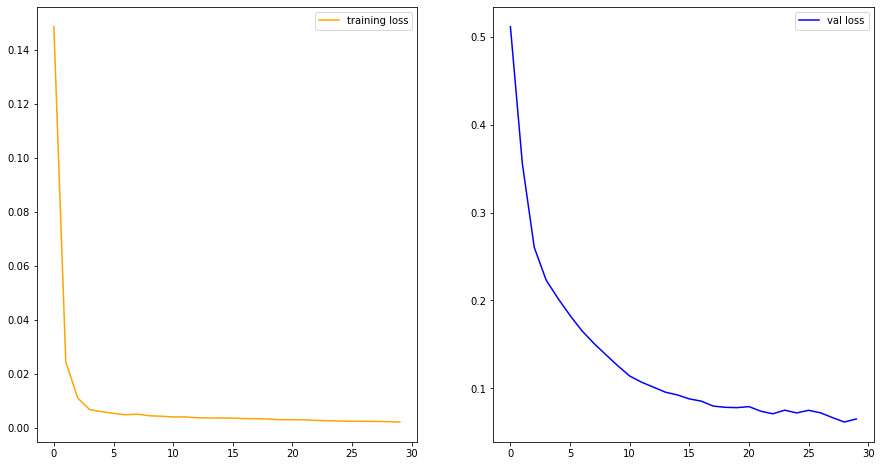

In [143]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15, 8))
sns.lineplot(x = nn_lstm.history.epoch,
             y = nn_lstm.history.history["loss"],
             color = "orange", label = "training loss", ax = ax1)
sns.lineplot(x = nn_lstm.history.epoch,
             y = nn_lstm.history.history["val_loss"],
             color = "blue", label = "val loss", ax = ax2)

In [144]:
close_train = scaler.inverse_transform(nn_lstm.predict(X_train))
close_test = scaler.inverse_transform(nn_lstm.predict(X_test))

19/19 [==============================] - 0s 1ms/step


In [145]:
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

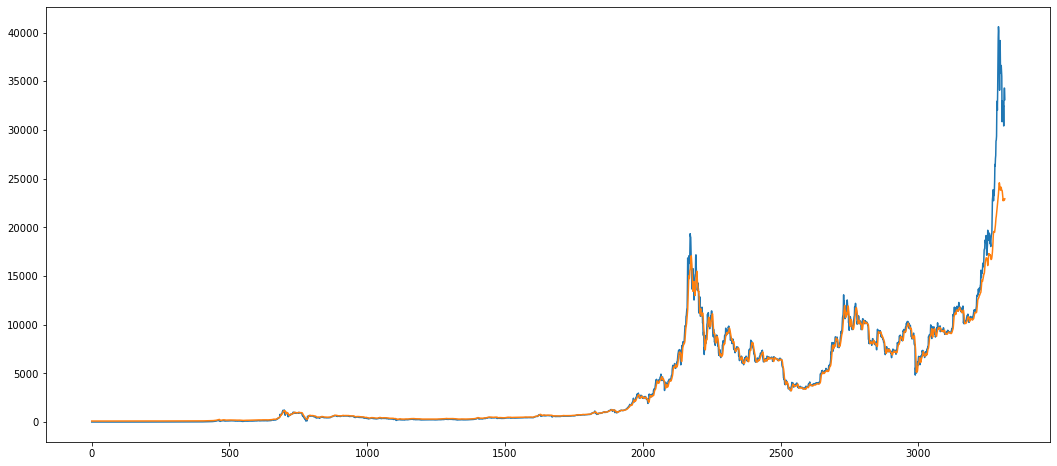

In [146]:
plt.plot(y_train)
plt.plot(close_train)

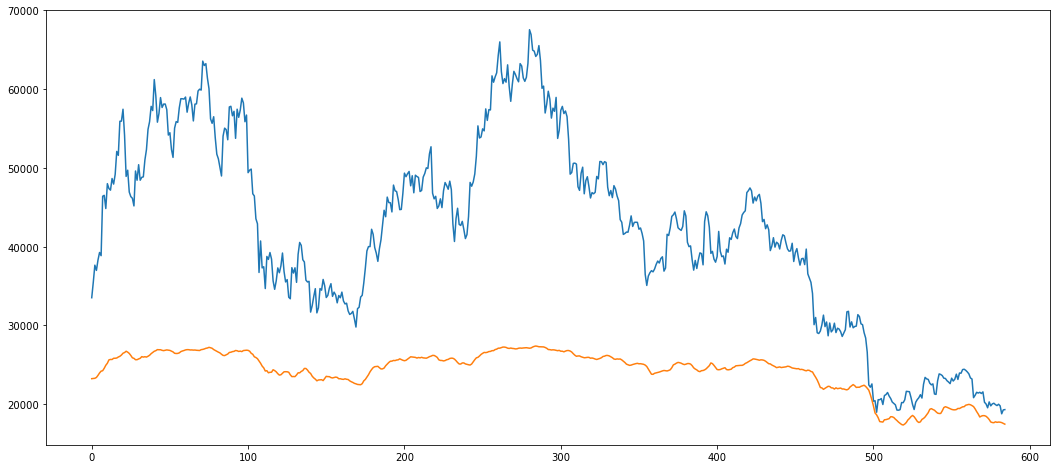

In [147]:
plt.plot(y_test)
plt.plot(close_test)